# Анализ факторов, влияющих на скорость принятия законопроектов: построение модели Кокса

Этот файл содержит полный процесс анализа данных о законопроектах, включающий предобработку данных, построение регрессионной модели Кокса и визуализацию результатов.

In [1]:
pip install lifelines

Note: you may need to restart the kernel to use updated packages.


In [272]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
from tabulate import tabulate
import warnings
import re
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.feature_extraction import FeatureHasher
from lifelines import (
    WeibullAFTFitter,
    LogNormalAFTFitter,
    LogLogisticAFTFitter,
)
from lifelines import LogNormalAFTFitter
from lifelines.statistics import proportional_hazard_test
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")

### Предобработка данных

Откроем файл с данными, которые получились после парсинга:

In [227]:
data = pd.read_csv('all_bills_6th_and_7th_convocation.csv')
data.head(5)

,Субъект права законодательной инициативы,Форма законопроекта,Ответственный комитет,Отрасль законодательства,Тематический блок законопроектов,Профильный комитет,Пакет документов при внесении,Номер,Ссылка,Дата внесения,...,Заключение Правительства РФ на законопроект,Предмет ведения,Комитеты-соисполнители,Вопрос ведения,Новая редакция законопроекта,Наличие актуального Заключения Правового Управления,Планируемый месяц рассмотрения согласно Примерной программе,Принадлежность к примерной программе,Срок представления поправок,Планируемая дата рассмотрения законопроекта согласно календарю
0,Депутат Государственной Думы Д.В.Ушаков,Федеральный закон,"Комитет Государственной Думы по труду, социаль...",060.000.000 Труд и занятость населения,Социальная политика,"Комитет Государственной Думы по труду, социаль...",NaN,№1187320-6,https://sozd.duma.gov.ru/bill/1187320-6,04.10.2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Депутат Государственной Думы Д.В.Ушаков,Федеральный закон,"Комитет Государственной Думы по труду, социаль...",060.000.000 Труд и занятость населения,Социальная политика,"Комитет Государственной Думы по труду, социаль...",NaN,№1187319-6,https://sozd.duma.gov.ru/bill/1187319-6,04.10.2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Депутаты Государственной Думы М.В.Емельянов, Д...",Федеральный закон,Комитет Государственной Думы по бюджету и налогам,NaN,"Бюджетное, налоговое, финансовое законодательство",Комитет Государственной Думы по бюджету и налогам,NaN,№1187318-6,https://sozd.duma.gov.ru/bill/1187318-6,04.10.2016,...,Не требуется,Совместное ведение,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Правительство Российской Федерации,Федеральный закон,Комитет Государственной Думы по делам Содружес...,200.000.000 Международные отношения. Междунаро...,Ратификация международных договоров Российской...,Комитет Государственной Думы по делам Содружес...,NaN,№1187317-6,https://sozd.duma.gov.ru/bill/1187317-6,04.10.2016,...,Не требуется,Ведение РФ,Комитет Государственной Думы по международным ...,Ведение Конституционного Суда РФ,NaN,NaN,NaN,NaN,NaN,NaN
4,Депутат Государственной Думы В.Н.Тетекин,Федеральный закон,Комитет Государственной Думы по бюджету и налогам,NaN,NaN,Комитет Государственной Думы по бюджету и налогам,NaN,№1187303-6,https://sozd.duma.gov.ru/bill/1187303-6,04.10.2016,...,NaN,Совместное ведение,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [228]:
data.columns

Index(['Субъект права законодательной инициативы', 'Форма законопроекта',
       'Ответственный комитет', 'Отрасль законодательства',
       'Тематический блок законопроектов', 'Профильный комитет',
       'Пакет документов при внесении', 'Номер', 'Ссылка', 'Дата внесения',
       'Дата принятия/не принятия', 'Статус', 'Созыв',
       'Заключение Правительства РФ на законопроект', 'Предмет ведения',
       'Комитеты-соисполнители', 'Вопрос ведения',
       'Новая редакция законопроекта',
       'Наличие актуального Заключения Правового Управления',
       'Планируемый месяц рассмотрения согласно Примерной программе',
       'Принадлежность к примерной программе', 'Срок представления поправок',
       'Планируемая дата рассмотрения законопроекта согласно календарю'],
      dtype='object')

In [229]:
data.shape

(12867, 23)

Полученные данные содержат столбцы, которые не будут использоваться в модели. Удалим их, оставив только те переменные, которые необходимы для дальнейшего анализа:

In [230]:
columns_to_drop = [
    'Заключение Правительства РФ на законопроект',
    'Предмет ведения',
    'Вопрос ведения',
    'Новая редакция законопроекта',
    'Наличие актуального Заключения Правового Управления',
    'Планируемый месяц рассмотрения согласно Примерной программе',
    'Принадлежность к примерной программе',
    'Срок представления поправок',
    'Планируемая дата рассмотрения законопроекта согласно календарю'
]

data = data.drop(columns=columns_to_drop)

In [231]:
columns_rename = {
    'Субъект права законодательной инициативы': 'Initiator',
    'Форма законопроекта': 'BillForm',
    'Ответственный комитет': 'ResponsibleCommittee',
    'Отрасль законодательства': 'LegislationSector',
    'Тематический блок законопроектов': 'ThematicBlock',
    'Профильный комитет': 'ProfileCommittee',
    'Пакет документов при внесении': 'SubmissionDocuments',
    'Номер': 'Number',
    'Ссылка': 'Link',
    'Дата внесения': 'SubmissionDate',
    'Дата принятия/не принятия': 'AdoptionDate',
    'Статус': 'Status',
    'Созыв': 'Convocation',
    'Комитеты-соисполнители': 'CoCommittees'
}

data = data.rename(columns=columns_rename)

In [232]:
billform_mapping = {
    'Федеральный закон': 'federal_law',
    'Федеральный конституционный закон': 'constitutional_federal_law',
    'Закон Российской Федерации о поправке к Конституции Российской Федерации': 'constitutional_amendment_law'
}


data['BillForm'] = data['BillForm'].map(billform_mapping)

In [233]:
data['ThematicBlock_cleaned'] = data['ThematicBlock']

data['ThematicBlock_cleaned'] = data['ThematicBlock_cleaned'].str.replace(
    'Бюджетное, налоговое, финансовое законодательство',
    'Бюджетное налоговое финансовое законодательство'
)

data['ThematicBlock_cleaned'] = data['ThematicBlock_cleaned'].str.replace(
    'Государственное строительство и конституционные права граждан, Оборона и безопасность',
    'Государственное строительство и конституционные права граждан; Оборона и безопасность'
)

data['Thematic_List'] = data['ThematicBlock_cleaned'].apply(
    lambda x: [i.strip() for i in x.split(';')] if isinstance(x, str) else []
)

thematic_mapping = {
    'Социальная политика': 'social_policy',
    'Бюджетное налоговое финансовое законодательство': 'budget_and_tax_policy',
    'Ратификация международных договоров Российской Федерации': 'international_treaties',
    'Экономическая политика': 'economic_policy',
    'Государственное строительство и конституционные права граждан': 'state_structure_and_constitutional_rights',
    'Оборона и безопасность': 'defense_and_security'
}

data['Thematic_List'] = data['Thematic_List'].apply(
    lambda lst: [thematic_mapping[i] for i in lst if i in thematic_mapping]
)

mlb = MultiLabelBinarizer()
theme_encoded = pd.DataFrame(
    mlb.fit_transform(data['Thematic_List']),
    columns=mlb.classes_
)

theme_encoded.drop(columns=['state_structure_and_constitutional_rights'], inplace=True)
data = pd.concat([data.reset_index(drop=True), theme_encoded.reset_index(drop=True)], axis=1)

Преобразуем статус законопроекта в числовой формат: принятие обозначим как 1, непринятие — как 0, чтобы использовать переменную в качестве целевой в модели.

In [234]:
data['Status_binary'] = data['Status'].map({'принят': 1, 'не принят': 0})

Вычислим продолжительность рассмотрения законопроекта в днях — от даты внесения до даты принятия.

In [235]:
data['SubmissionDate'] = pd.to_datetime(data['SubmissionDate'], errors='coerce', dayfirst=True)
data['AdoptionDate'] = pd.to_datetime(data['AdoptionDate'], errors='coerce', dayfirst=True)
data['Duration'] = (data['AdoptionDate'] - data['SubmissionDate']).dt.days

In [236]:
data.head(4)

,Initiator,BillForm,ResponsibleCommittee,LegislationSector,ThematicBlock,ProfileCommittee,SubmissionDocuments,Number,Link,SubmissionDate,...,CoCommittees,ThematicBlock_cleaned,Thematic_List,budget_and_tax_policy,defense_and_security,economic_policy,international_treaties,social_policy,Status_binary,Duration
0,Депутат Государственной Думы Д.В.Ушаков,federal_law,"Комитет Государственной Думы по труду, социаль...",060.000.000 Труд и занятость населения,Социальная политика,"Комитет Государственной Думы по труду, социаль...",NaN,№1187320-6,https://sozd.duma.gov.ru/bill/1187320-6,2016-10-04,...,NaN,Социальная политика,[social_policy],0,0,0,0,1,0,157
1,Депутат Государственной Думы Д.В.Ушаков,federal_law,"Комитет Государственной Думы по труду, социаль...",060.000.000 Труд и занятость населения,Социальная политика,"Комитет Государственной Думы по труду, социаль...",NaN,№1187319-6,https://sozd.duma.gov.ru/bill/1187319-6,2016-10-04,...,NaN,Социальная политика,[social_policy],0,0,0,0,1,0,157
2,"Депутаты Государственной Думы М.В.Емельянов, Д...",federal_law,Комитет Государственной Думы по бюджету и налогам,NaN,"Бюджетное, налоговое, финансовое законодательство",Комитет Государственной Думы по бюджету и налогам,NaN,№1187318-6,https://sozd.duma.gov.ru/bill/1187318-6,2016-10-04,...,NaN,Бюджетное налоговое финансовое законодательство,[budget_and_tax_policy],1,0,0,0,0,0,169
3,Правительство Российской Федерации,federal_law,Комитет Государственной Думы по делам Содружес...,200.000.000 Международные отношения. Междунаро...,Ратификация международных договоров Российской...,Комитет Государственной Думы по делам Содружес...,NaN,№1187317-6,https://sozd.duma.gov.ru/bill/1187317-6,2016-10-04,...,Комитет Государственной Думы по международным ...,Ратификация международных договоров Российской...,[international_treaties],0,0,0,1,0,1,86


In [237]:
data_old = data.copy()

Сделаем новый столбец с именем актора и очистим иницатора до института, который предлагал законопроект на рассмотрение.

In [238]:
def extract_actor(initiator):
    matches = re.findall(r'[А-ЯЁ]\.[А-ЯЁ]\.[А-ЯЁ][а-яё]+', initiator)
    if matches:
        return ', '.join(matches)
    return None
def remove_actor(initiator):
    return re.sub(r'[А-ЯЁ]\.[А-ЯЁ]\.[А-ЯЁ][а-яё]+', '', initiator).strip()

data['Actors'] = data['Initiator'].apply(extract_actor)
data['Initiator'] = data['Initiator'].apply(remove_actor)

In [239]:
def extract_institution_names(text):
    if not isinstance(text, str):
        return None

    text = text.lower()
    text = re.sub(r'[^\w\s\-\(\)]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    matches = re.findall(
        r'((?:[а-яё]+\s+){0,4}(?:дума|собрание|совет|хурал|парламент|правительство)[а-яё\s\-\(\)]{0,30})',
        text
    )

    cleaned = set()
    for m in matches:
        phrase = m.strip()
        if len(phrase.split()) >= 2 and 'депутат' not in phrase:
            cleaned.add(phrase)

    if re.search(r'депутат(ы)?\s+государственной\s+думы', text):
        cleaned.add('депутаты государственной думы')
    if re.search(r'члены?\s+совета\s+федерации', text):
        cleaned.add('члены совета федерации')
    if 'правительство российской федерации' in text:
        cleaned.add('правительство российской федерации')
    if re.search(r'президент\s+российской\s+федерации', text):
        cleaned.add('президент российской федерации')
    if re.search(r'(верховный|высший арбитражный|арбитражный)\s+суд', text):
        cleaned.add('суд российской федерации')
    if re.search(r'сенатор(ы)?\s+российской\s+федерации', text):
        cleaned.add('члены совета федерации')
    if re.search(r'областн\w*\s+(совет|собрание)\s+депутатов', text):
        cleaned.add('региональный парламент')
    if re.search(r'совет\s+народных\s+депутатов', text):
        cleaned.add('региональный парламент')
    if re.search(r'собрание\s+депутатов\s+[а-яё\s\-]+', text):
        cleaned.add('региональный парламент')


    return '; '.join(sorted(cleaned)) if cleaned else None
data['Initiator'] = data['Initiator'].apply(extract_institution_names)

Стандартизируем инициаторов: объединяем схожие формулировки (например, "депутаты Госдумы" и "депутат Госдумы") и кодируем их в числовой формат для дальнейшего анализа.

In [240]:
actor_normalization = {
    'депутаты государственной думы': 'state_duma',
    'депутат государственной думы': 'state_duma',
    'члены совета федерации': 'federation_council',
    'член совета федерации': 'federation_council',
    'правительство российской федерации': 'government',
    'президент российской федерации': 'president',
    'суд российской федерации': 'court',
    'региональный парламент': 'regional_parliament',
    'законодательное собрание': 'regional_parliament',
    'областная дума': 'regional_parliament',
    'губернская дума': 'regional_parliament',
    'государственное собрание': 'regional_parliament',
    'народное собрание': 'regional_parliament',
    'государственный совет': 'regional_parliament',
    'верховный хурал': 'regional_parliament',
    'дума': 'regional_parliament',
    'парламент': 'regional_parliament',
}

def standardize_actors(text):
    if not isinstance(text, str):
        return None
    text = text.lower()
    
    text = re.sub(r'[,;]+', ';', text)
    text = re.sub(r'\s{2,}', ' ', text)
    
    parts = [p.strip() for p in text.split(';') if p.strip()]
    
    normalized = set()
    for part in parts:
        for key, replacement in actor_normalization.items():
            if key in part:
                normalized.add(replacement)
                break  
    return ';'.join(sorted(normalized)) if normalized else None
data['Initiator'] = data['Initiator'].apply(standardize_actors)

In [241]:
data['Initiator_List'] = data['Initiator'].apply(lambda x: x.split(';') if isinstance(x, str) else [])

mlb = MultiLabelBinarizer()
binary_encoded = mlb.fit_transform(data['Initiator_List'])

binary_df = pd.DataFrame(binary_encoded, columns=[f"actor_{c}" for c in mlb.classes_])
binary_df = binary_df.drop(columns=["actor_state_duma"])
data = pd.concat([data.reset_index(drop=True), binary_df.reset_index(drop=True)], axis=1)

Теперь посчитаем, сколько инициаторов участвовало в каждом законопроекте.

In [242]:
data['Actors_Count'] = data['Actors'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

Закодируем категориальные переменные, BillForm и ThematicBlock, через one-hot (так как категорий немного), а ResponsibleCommittee — через hash encoding, чтобы сократить размерность (исходных комитетов 56).

In [243]:
billform_ohe = pd.get_dummies(data['BillForm'], prefix='billform', drop_first=True).astype(int)

data = pd.concat([data, billform_ohe], axis=1)

In [244]:
committee_series = data['ResponsibleCommittee'].fillna('missing').astype(str)

committee_values = committee_series.tolist()

hasher = FeatureHasher(n_features=8, input_type='string', alternate_sign=False)  

committee_hashed = hasher.transform([[x] for x in committee_values])  

committee_hashed_df = pd.DataFrame(
    committee_hashed.toarray(),
    columns=[f'committee_hash_{i}' for i in range(8)]
)

data = pd.concat([data.reset_index(drop=True), committee_hashed_df.reset_index(drop=True)], axis=1)

Преобразуем переменную, обозначающую законодательный созыв, в бинарную переменную.

In [245]:
data['convocation_binary'] = data['Convocation'].map({6: 0, 7: 1})

Перейдем к определению аффиляции депутатов с правительством. В датафрейме с биографией закодируем аффиляцию как наличие опыта государственной службы, а также приведём ФИО к сокращенному формату для удобства дальнейшего сопоставления с основным датафреймом.

In [246]:
data_aff_gov = pd.read_csv('Deputies 6.csv', sep=';') 
data_aff_gov.head(3)

,Id,Surname,Name,Patronymic,CurrentPosition,IsActive,Sex,BirthDate,DeathDate,AcademicTitle_1,...,Region_22,Region_Session_22,Senator_Council_Branch_1,Senator_Council_Region_1,Senator_Council_Start_1,Senator_Council_End_1,Senator_Council_Branch_2,Senator_Council_Region_2,Senator_Council_Start_2,Senator_Council_End_2
0,99100052,Булавинов,Вадим,Евгеньевич,Депутат,не активен,Male,20.03.1963,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,99100099,Говорухин,Станислав,Сергеевич,Депутат,не активен,Male,29.03.1936,14.06.2018,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,99100110,Грешневиков,Анатолий,Николаевич,Депутат,активен,Male,29.08.1956,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [247]:
def format_name(row):
    if pd.isnull(row['Surname']) or pd.isnull(row['Name']):
        return None
    initials = row['Name'][0] + '.'
    if pd.notnull(row['Patronymic']) and isinstance(row['Patronymic'], str) and len(row['Patronymic']) > 0:
        initials += row['Patronymic'][0] + '.'
    return f"{initials}{row['Surname']}"

data_aff_gov['Short_Name'] = data_aff_gov.apply(format_name, axis=1)

In [248]:
affiliation_pattern = r'государственная служба|государственная корпорация|партийный работник|силовые структуры'

data_aff_gov['Is_Affiliated'] = (
    data_aff_gov['WorkplaceGroup']
    .astype(str)
    .str.contains(affiliation_pattern, case=False, na=False)
    .astype(int)
)

Добавим аффиляцию в исходный датафрейм.

In [249]:
affiliated_dict = data_aff_gov.set_index('Short_Name')['Is_Affiliated'].to_dict()

def check_affiliation(actor_string):
    if not isinstance(actor_string, str):
        return 0
    actor_list = [a.strip() for a in actor_string.split(',')]
    return int(any(affiliated_dict.get(actor, 0) == 1 for actor in actor_list))
    
data['Affiliation'] = data['Actors'].apply(check_affiliation)

Добавим переменную, отражающую количество дней, оставшихся до окончания созыва на момент подачи законопроекта.

In [250]:
convocation_end_dates = {
    6: pd.to_datetime('2016-10-04'),
    7: pd.to_datetime('2021-09-30')
}


data['convocation_end_date'] = data['Convocation'].map(convocation_end_dates)
data['DaysToEnd'] = (data['convocation_end_date'] - data['SubmissionDate']).dt.days

Определим уровень политической неопределённости на момент подачи законопроекта, используя индекс Economic Policy Uncertainty. Для каждой даты подачи законопроекта сопоставлено ближайшее по времени значение индекса, рассчитанного на основе анализа новостных публикаций. 

In [251]:
df_polunc = pd.read_excel('Russia_Policy_Uncertainty_Data-2.xlsx')

In [252]:
df_polunc = df_polunc.dropna(subset=['Year', 'Month'])
df_polunc['Month'] = df_polunc['Month'].astype(int)
df_polunc['date'] = pd.to_datetime(df_polunc['Year'].astype(str) + '-' + df_polunc['Month'].astype(str) + '-01')
df_polunc.rename(columns={'News-Based Policy Uncertainty Index': 'uncertainty_index'}, inplace=True)
df_polunc = df_polunc[['date', 'uncertainty_index']]

def find_closest_index(submission_date):
    diffs = abs(df_polunc['date'] - submission_date)
    idx_min = diffs.idxmin()
    return df_polunc.loc[idx_min, 'uncertainty_index']

data['uncertainty_index'] = data['SubmissionDate'].apply(find_closest_index)

In [253]:
data['submission_year'] = data['SubmissionDate'].dt.year

Удалим все не нужные столбцы.

In [254]:
columns_to_drop = [
    'SubmissionDate', 'AdoptionDate',
    'BillForm', 'ThematicBlock', 'Status',
    'ResponsibleCommittee', 'LegislationSector',
    'ProfileCommittee', 'Number', 'Link',
    'Convocation', 'CoCommittees', 'SubmissionDocuments',
    'Actors', 'Initiator_List', 'Initiator', 'convocation_end_date',
    'ThematicBlock_cleaned', 'Thematic_List'
]

data = data.drop(columns=columns_to_drop)

In [255]:
data.isna().sum()

budget_and_tax_policy                  0
defense_and_security                   0
economic_policy                        0
international_treaties                 0
social_policy                          0
Status_binary                          0
Duration                               0
actor_court                            0
actor_federation_council               0
actor_government                       0
actor_president                        0
actor_regional_parliament              0
Actors_Count                           0
billform_constitutional_federal_law    0
billform_federal_law                   0
committee_hash_0                       0
committee_hash_1                       0
committee_hash_2                       0
committee_hash_3                       0
committee_hash_4                       0
committee_hash_5                       0
committee_hash_6                       0
committee_hash_7                       0
convocation_binary                     0
Affiliation     

In [256]:
data.dtypes

budget_and_tax_policy                    int64
defense_and_security                     int64
economic_policy                          int64
international_treaties                   int64
social_policy                            int64
Status_binary                            int64
Duration                                 int64
actor_court                              int64
actor_federation_council                 int64
actor_government                         int64
actor_president                          int64
actor_regional_parliament                int64
Actors_Count                             int64
billform_constitutional_federal_law      int64
billform_federal_law                     int64
committee_hash_0                       float64
committee_hash_1                       float64
committee_hash_2                       float64
committee_hash_3                       float64
committee_hash_4                       float64
committee_hash_5                       float64
committee_has

### EDA 

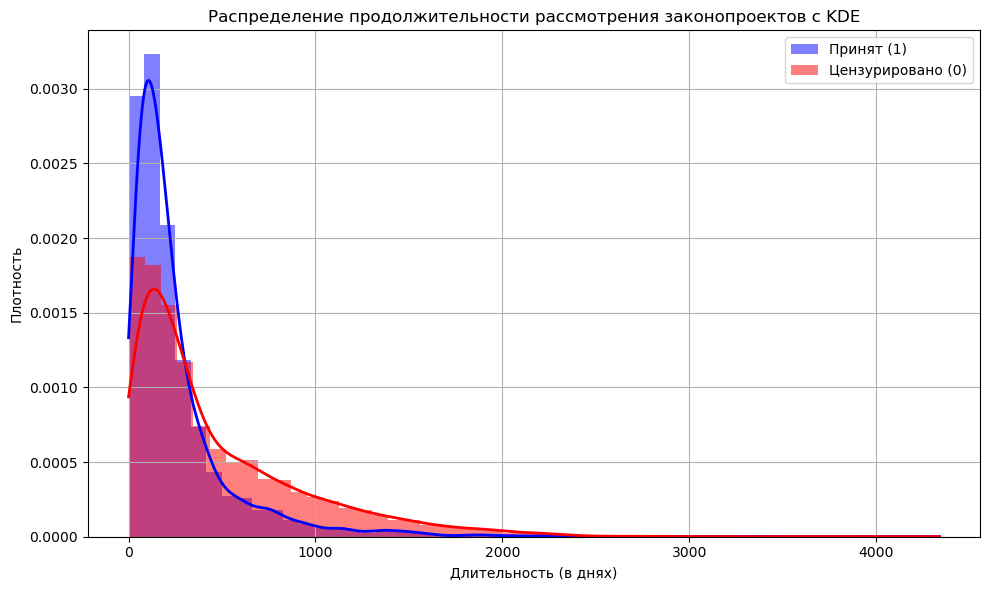

In [27]:
accepted = data[data['Status_binary'] == 1]['Duration'].dropna()
censored = data[data['Status_binary'] == 0]['Duration'].dropna()

plt.figure(figsize=(10, 6))
plt.hist(accepted, bins=50, alpha=0.5, label='Принят (1)', color='blue', density=True)
plt.hist(censored, bins=50, alpha=0.5, label='Цензурировано (0)', color='red', density=True)

x_vals = np.linspace(data['Duration'].min(), data['Duration'].max(), 1000)

kde_accepted = gaussian_kde(accepted)
kde_censored = gaussian_kde(censored)

plt.plot(x_vals, kde_accepted(x_vals), color='blue', linewidth=2)
plt.plot(x_vals, kde_censored(x_vals), color='red', linewidth=2)

plt.title('Распределение продолжительности рассмотрения законопроектов с KDE')
plt.xlabel('Длительность (в днях)')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

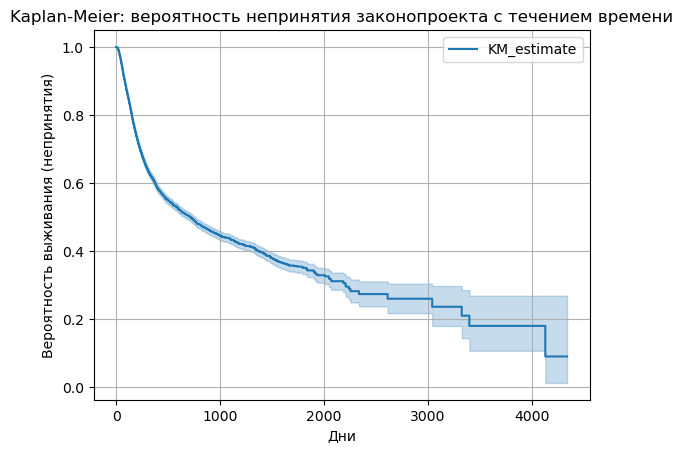

In [373]:
kmf = KaplanMeierFitter()
kmf.fit(durations=data['Duration'], event_observed=data['Status_binary'])
kmf.plot_survival_function()
plt.title('Kaplan-Meier: вероятность непринятия законопроекта с течением времени')
plt.xlabel('Дни')
plt.ylabel('Вероятность выживания')
plt.grid(True)
plt.show()

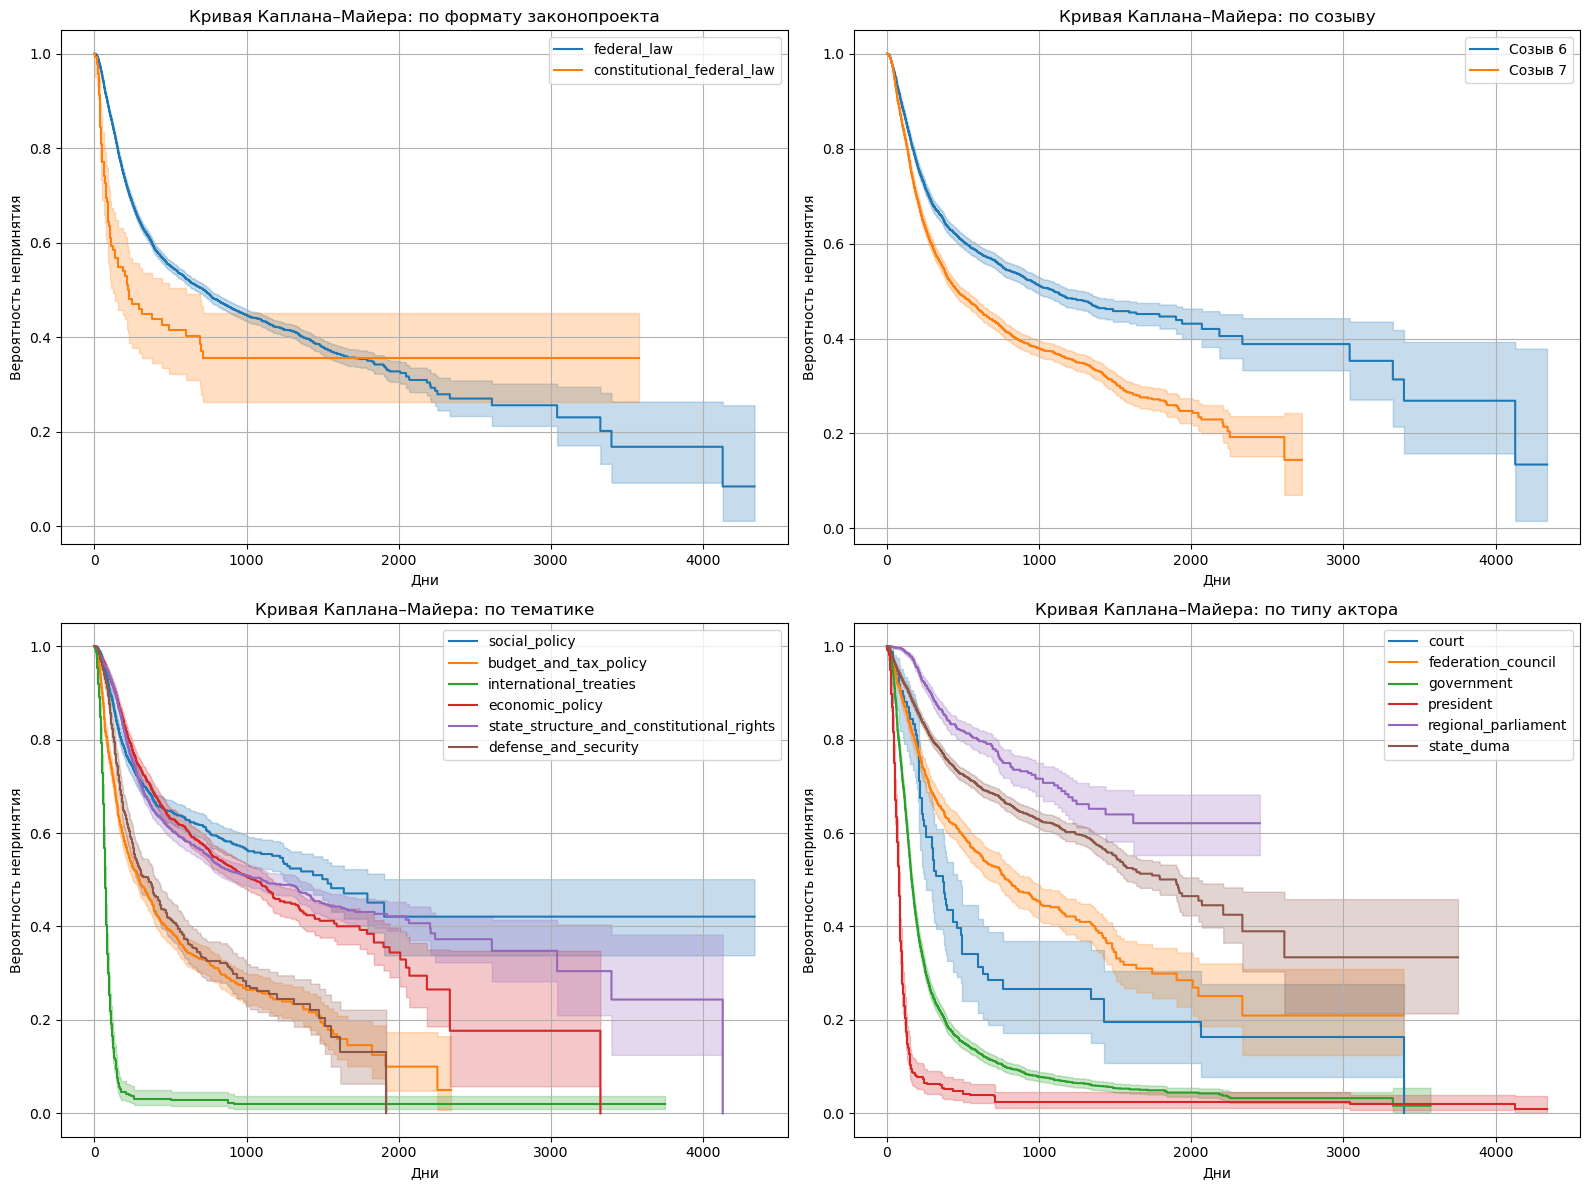

In [74]:
actor_cols = [col for col in data.columns if col.startswith('actor_')]

kmf = KaplanMeierFitter()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
for category in data_old['BillForm'].dropna().unique():
    mask = data_old['BillForm'] == category
    if mask.sum() > 50:
        kmf.fit(data_old[mask]['Duration'], event_observed=data_old[mask]['Status_binary'], label=category)
        kmf.plot_survival_function(ax=ax)
ax.set_title('Кривая Каплана–Майера: по формату законопроекта')
ax.set_xlabel('Дни')
ax.set_ylabel('Вероятность непринятия')
ax.grid(True)

ax = axes[0, 1]
for conv in sorted(data['convocation_binary'].unique()):
    mask = data['convocation_binary'] == conv
    label = f"Созыв {6 + conv}"
    if mask.sum() > 50:
        kmf.fit(data[mask]['Duration'], event_observed=data[mask]['Status_binary'], label=label)
        kmf.plot_survival_function(ax=ax)
ax.set_title('Кривая Каплана–Майера: по созыву')
ax.set_xlabel('Дни')
ax.set_ylabel('Вероятность непринятия')
ax.grid(True)


ax = axes[1, 0]
for category in data_old['ThematicBlock'].dropna().unique():
    mask = data_old['ThematicBlock'] == category
    if mask.sum() > 50:
        kmf.fit(data_old[mask]['Duration'], event_observed=data_old[mask]['Status_binary'], label=category)
        kmf.plot_survival_function(ax=ax)
ax.set_title('Кривая Каплана–Майера: по тематике')
ax.set_xlabel('Дни')
ax.set_ylabel('Вероятность непринятия')
ax.grid(True)

ax = axes[1, 1]
actor_cols = [col for col in data.columns if col.startswith('actor_')]
for col in actor_cols:
    mask = data[col] == 1
    if mask.sum() > 50:
        kmf.fit(data[mask]['Duration'], event_observed=data[mask]['Status_binary'], label=col.replace('actor_', ''))
        kmf.plot_survival_function(ax=ax)
ax.set_title('Кривая Каплана–Майера: по типу актора')
ax.set_xlabel('Дни')
ax.set_ylabel('Вероятность непринятия')
ax.grid(True)

plt.tight_layout()
plt.show()

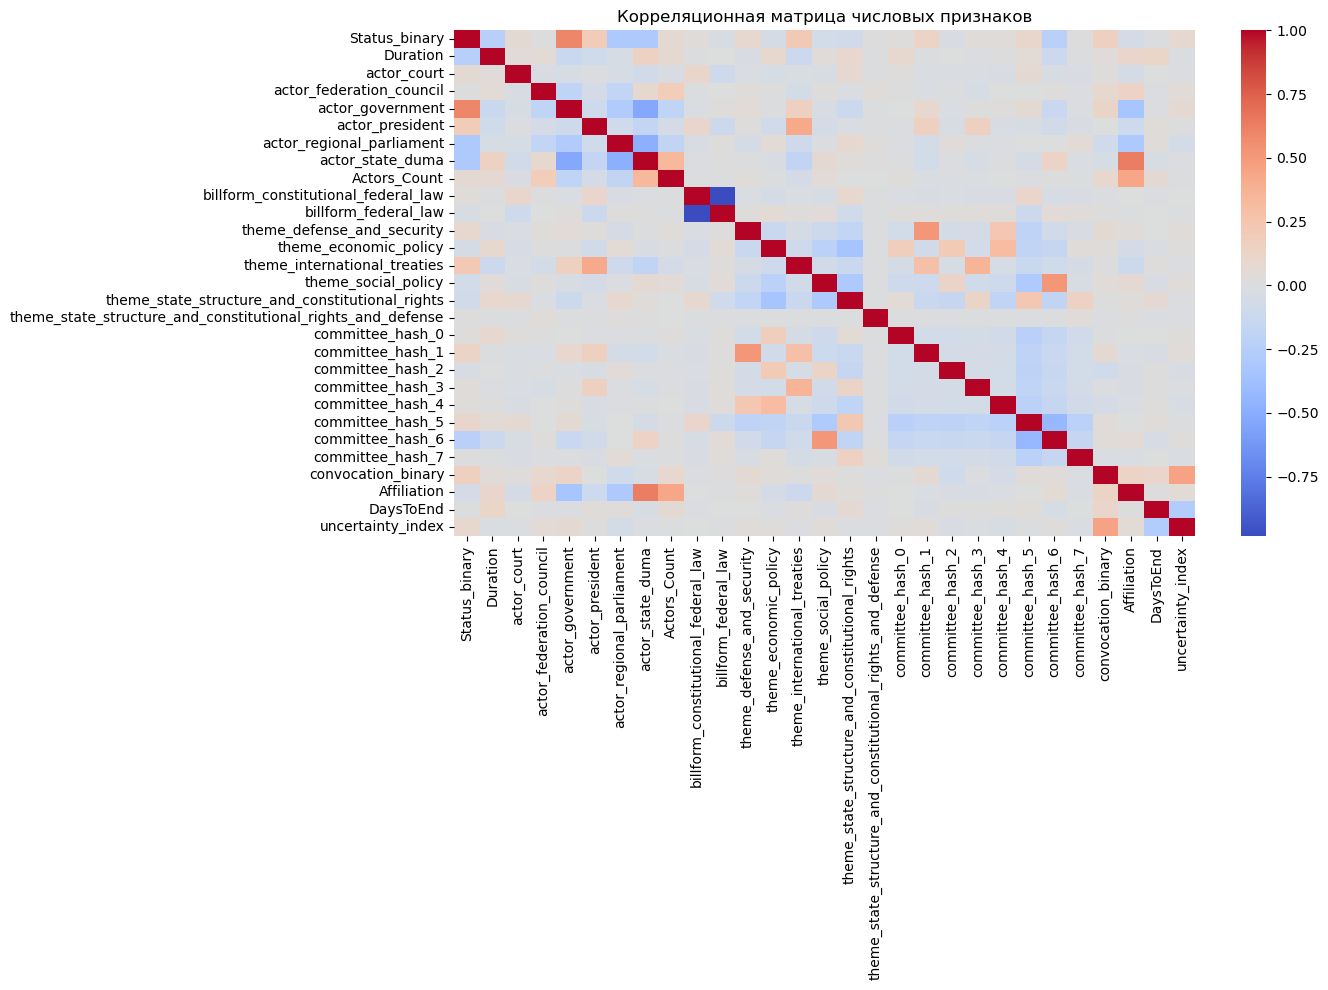

In [75]:
plt.figure(figsize=(14, 10))
sns.heatmap(data.corr(numeric_only=True), cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()

Рассчитаем медиану времени рассмотрения законопроекта.

In [430]:
kmf.fit(durations=data['Duration'], event_observed=data['Status_binary'])  
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
median_confidence_interval_.columns = ['lower_0.95', 'upper_0.95']
print(median_)
print(median_confidence_interval_)

713.0
     lower_0.95  upper_0.95
0.5       657.0       757.0


## Построение моделей

После описательного построим полупараметрическую модель пропорциональных рисков Кокса.

Вначале проверим данные на наличие мультиколлинеарности с помощью расчёта коэффициента VIF (Variance Inflation Factor).

In [257]:
feature_cols = [col for col in data.columns if col not in ['duration', 'event']]
X = data[feature_cols].dropna().astype(float)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values('VIF', ascending=False))

                                feature           VIF
20                     committee_hash_5  1.900263e+07
21                     committee_hash_6  1.125679e+07
15                     committee_hash_0  3.727853e+06
22                     committee_hash_7  3.584727e+06
19                     committee_hash_4  3.492020e+06
17                     committee_hash_2  3.151640e+06
16                     committee_hash_1  2.884853e+06
18                     committee_hash_3  2.656693e+06
27                      submission_year  8.973955e+01
23                   convocation_binary  7.635588e+01
14                 billform_federal_law  2.855231e+01
13  billform_constitutional_federal_law  2.848350e+01
25                            DaysToEnd  2.456148e+01
9                      actor_government  2.829514e+00
5                         Status_binary  2.233728e+00
1                  defense_and_security  1.835143e+00
24                          Affiliation  1.802190e+00
3                internation

Хешированные признаки комитетов оказались сильно коррелированы между собой. Чтобы устранить мультиколлинеарность, снизим размерность с помощью метода главных компонент (PCA).

In [258]:
committee_hash_cols = [col for col in data.columns if col.startswith('committee_hash_')]
pca = PCA(n_components=2)
committee_pca = pca.fit_transform(data[committee_hash_cols])

data['committee_pca_0'] = committee_pca[:, 0]
data['committee_pca_1'] = committee_pca[:, 1]
data.drop(columns=committee_hash_cols, inplace=True)

После обработки пересчитаем VIF, чтобы убедиться в отсутствии мультиколлинеарности перед построением модели.

In [259]:
feature_cols = [col for col in data.columns if col not in ['duration', 'event']]
X = data[feature_cols].dropna().astype(float)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values('VIF', ascending=False))

                                feature          VIF
19                      submission_year  2606.161106
14                 billform_federal_law  2568.294361
13  billform_constitutional_federal_law    28.783377
18                    uncertainty_index     6.044303
17                            DaysToEnd     4.836803
9                      actor_government     3.676703
5                         Status_binary     3.668906
15                   convocation_binary     2.631521
16                          Affiliation     2.476812
6                              Duration     2.176968
11            actor_regional_parliament     1.985135
4                         social_policy     1.870925
2                       economic_policy     1.717858
10                      actor_president     1.599777
20                      committee_pca_0     1.571589
0                 budget_and_tax_policy     1.509191
12                         Actors_Count     1.488431
3                international_treaties     1.

Теперь построим саму модель.

In [261]:
exclude = [
    'Duration',          
    'Status_binary',     
    'submission_year'
]

covariates = [col for col in data.columns if col not in exclude]
formula = ' + '.join(covariates)

cph = CoxPHFitter(penalizer=0.1, l1_ratio=0)
cph.fit(
    data,
    duration_col='Duration',
    event_col='Status_binary',
    strata=['submission_year'],  
    formula=formula,
    robust=True 
)

cph.print_summary()

model,lifelines.CoxPHFitter
duration col,'Duration'
event col,'Status_binary'
penalizer,0.1
l1 ratio,0
robust variance,True
strata,submission_year
baseline estimation,breslow
number of observations,12867
number of events observed,5057
partial log-likelihood,-30366.16


In [268]:
results_df = cph.summary.copy()
results_df_rounded = results_df.round(2)

label_map_ru = {
    'committee_pca_1': 'Комитет (PCA 1)',
    'committee_pca_0': 'Комитет (PCA 0)',
    'uncertainty_index': 'Индекс неопределённости',
    'DaysToEnd': 'Дней до конца созыва',
    'Affiliation': 'Принадлежность к Правительству',
    'convocation_binary': 'Созыв (7)',
    'billform_federal_law': 'Федеральный закон',
    'billform_constitutional_federal_law': 'Конст. фед. закон',
    'Actors_Count': 'Число акторов',
    'actor_regional_parliament': 'Региональный парламент',
    'actor_president': 'Президент',
    'actor_government': 'Правительство',
    'actor_federation_council': 'Совет Федерации',
    'actor_court': 'Суд',
    'social_policy': 'Социальная политика',
    'international_treaties': 'Международные соглашения',
    'economic_policy': 'Экономическая политика',
    'defense_and_security': 'Оборона и безопасность',
    'budget_and_tax_policy': 'Бюджетная и налоговая политика',
}

results_df_rounded.index = [
    label_map_ru.get(label, label.replace('_', ' ')) for label in results_df_rounded.index
]

columns_to_keep = [
    'coef', 'exp(coef)', 'se(coef)', 'coef lower 95%', 'coef upper 95%', 'z', 'p'
]
results_df_rounded[columns_to_keep].to_csv("cox_model_clean_rounded_rus.csv", encoding='utf-8-sig')

И визуализируем коэффициенты.

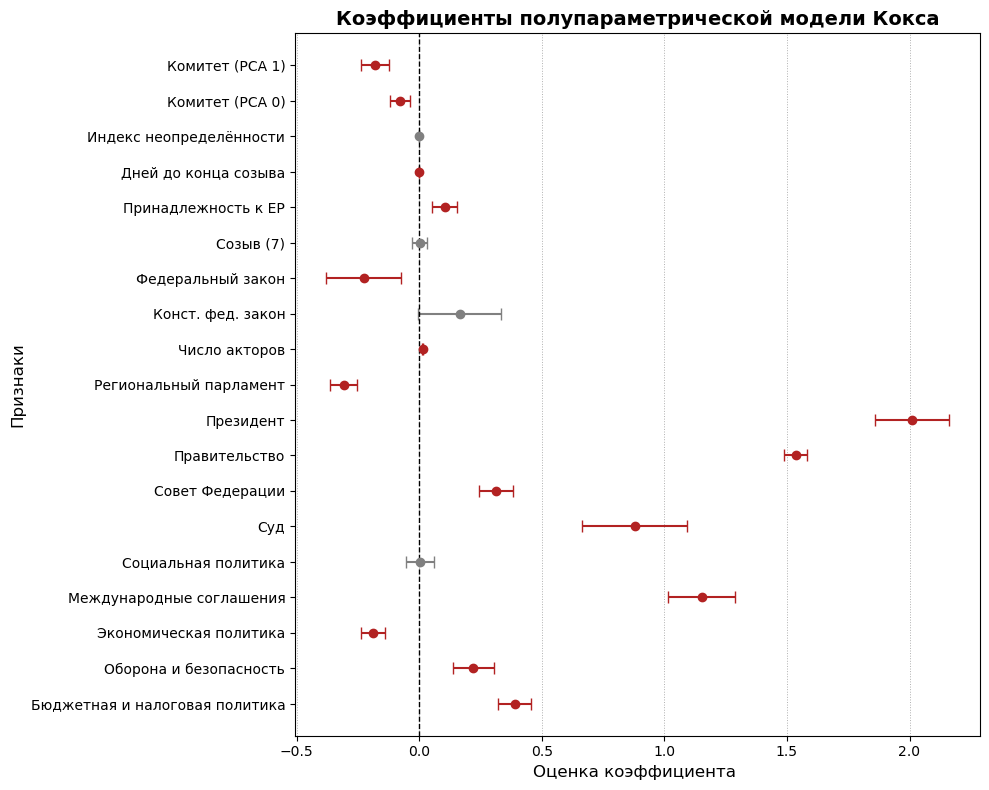

In [299]:
summary = cph.summary.copy()
summary = summary[~summary.index.str.startswith('baseline')]
significant = summary['p'] < 0.05

labels_ru = [label_map_ru.get(label, label.replace('_', ' ')) for label in summary.index]

plt.figure(figsize=(10, 8))
for i, (coef, err, sig) in enumerate(zip(summary['coef'], summary['se(coef)'], significant)):
    color = 'firebrick' if sig else 'gray'
    plt.errorbar(
        x=coef,
        y=i,
        xerr=1.96 * err,
        fmt='o',
        color=color,
        ecolor=color,
        capsize=4,
        label='_nolegend_'
    )

plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

plt.yticks(range(len(labels_ru)), labels_ru, fontsize=10)
plt.xlabel('Оценка коэффициента ', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.title('Коэффициенты полупараметрической модели Кокса', fontsize=14, weight='bold')
plt.grid(axis='x', linestyle=':', linewidth=0.7)
plt.tight_layout()
plt.show()

Перейдём к построению параметрической модели выживания. Прежде чем выбрать конкретную модель, определим, какое распределение времени до события наилучшим образом соответствует нашим данным.

In [276]:
df = data.copy()
df = pd.get_dummies(df, columns=['submission_year'], drop_first=True, dtype=float)
df = df[df['Duration'] > 0].copy()

exclude = ['Duration', 'Status_binary']

covars = [c for c in df.columns if c not in exclude]
formula = ' + '.join(covars)

aft_models = {
    "WeibullAFT":     WeibullAFTFitter(penalizer=0.1),
    "LogNormalAFT":   LogNormalAFTFitter(penalizer=0.1),
    "LogLogisticAFT": LogLogisticAFTFitter(penalizer=0.1),
}

print("\nAIC разных распределений:")
for name, model in aft_models.items():
    model.fit(
        df,
        duration_col='Duration',
        event_col='Status_binary',
        formula=formula
    )
    print(f"{name:12}: AIC = {model.AIC_:,.2f}")


AIC разных распределений:
WeibullAFT  : AIC = 75,111.12
LogNormalAFT: AIC = 74,456.58
LogLogisticAFT: AIC = 74,404.77


Наименьшее значение AIC наблюдается у логлогистического распределения, что говорит о его лучшем соответствии данным по сравнению с другими вариантами. Используем его для оценки коэффициентов в модели ускоренного времени.

In [283]:
aft = LogLogisticAFTFitter(penalizer=0.1)
aft.fit(
    df,
    duration_col='Duration',
    event_col='Status_binary',
    formula=formula,
    robust=True             
)

summary = aft.summary.copy()                                    
year_mask = summary.index.get_level_values(1).str.startswith('submission_year_')
summary = summary.loc[~year_mask]                               
summary = summary.reset_index().rename(columns={'index': 'param_covariate'})

float_cols = summary.select_dtypes('float').columns
summary[float_cols] = summary[float_cols].applymap(lambda x: f'{x:,.6g}')

from IPython.display import display
display(summary)  

,param,covariate,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
0,alpha_,Intercept,6.76959,870.952,0.0859928,6.60104,6.93813,735.864,"1,030.84",0,78.7228,0,inf
1,alpha_,budget_and_tax_policy,-0.431639,0.649444,0.0350313,-0.500299,-0.362978,0.606349,0.695601,0,-12.3215,6.93878e-35,113.473
2,alpha_,defense_and_security,-0.219982,0.802533,0.0416496,-0.301613,-0.13835,0.739624,0.870794,0,-5.28173,1.27969e-07,22.8977
3,alpha_,economic_policy,0.236672,1.26703,0.0290467,0.179742,0.293603,1.19691,1.34125,0,8.14799,3.70026e-16,51.2632
4,alpha_,international_treaties,-0.956256,0.384329,0.0364579,-1.02771,-0.8848,0.357825,0.412797,0,-26.2291,1.23882e-151,501.302
5,alpha_,social_policy,0.0329412,1.03349,0.0329611,-0.0316612,0.0975437,0.968835,1.10246,0,0.999399,0.317601,1.65471
6,alpha_,actor_court,-0.85766,0.424154,0.226343,-1.30128,-0.414034,0.272182,0.660978,0,-3.78919,0.000151136,12.6919
7,alpha_,actor_federation_council,-0.320045,0.726117,0.0468234,-0.411817,-0.228272,0.662446,0.795908,0,-6.83513,8.19281e-12,36.8288
8,alpha_,actor_government,-1.61837,0.198222,0.0434462,-1.70352,-1.53321,0.182041,0.215841,0,-37.2499,1.06345e-303,"1,006.46"
9,alpha_,actor_president,-1.95649,0.141353,0.108519,-2.16919,-1.7438,0.11427,0.174854,0,-18.0291,1.15197e-72,238.975


In [303]:
summary = aft.summary.copy()
year_mask = summary.index.get_level_values(1).str.startswith('submission_year_')
summary = summary.loc[~year_mask]

summary = summary.reset_index().rename(columns={
    'level_0': 'parameter',
    'level_1': 'covariate'
})

summary['covariate_ru'] = summary['covariate'].map(label_map_ru).fillna(summary['covariate'])

columns_to_keep = [
    'covariate_ru', 'coef', 'exp(coef)', 'se(coef)',
    'coef lower 95%', 'coef upper 95%', 'z', 'p'
]
summary_final = summary[columns_to_keep].copy()
summary_final = summary_final.rename(columns={'covariate_ru': 'Признак'})
summary_final = summary_final.round(2)

summary_final.to_csv('aft_model_clean_rus.csv', index=False, encoding='utf-8-sig')

И визуализируем результаты.

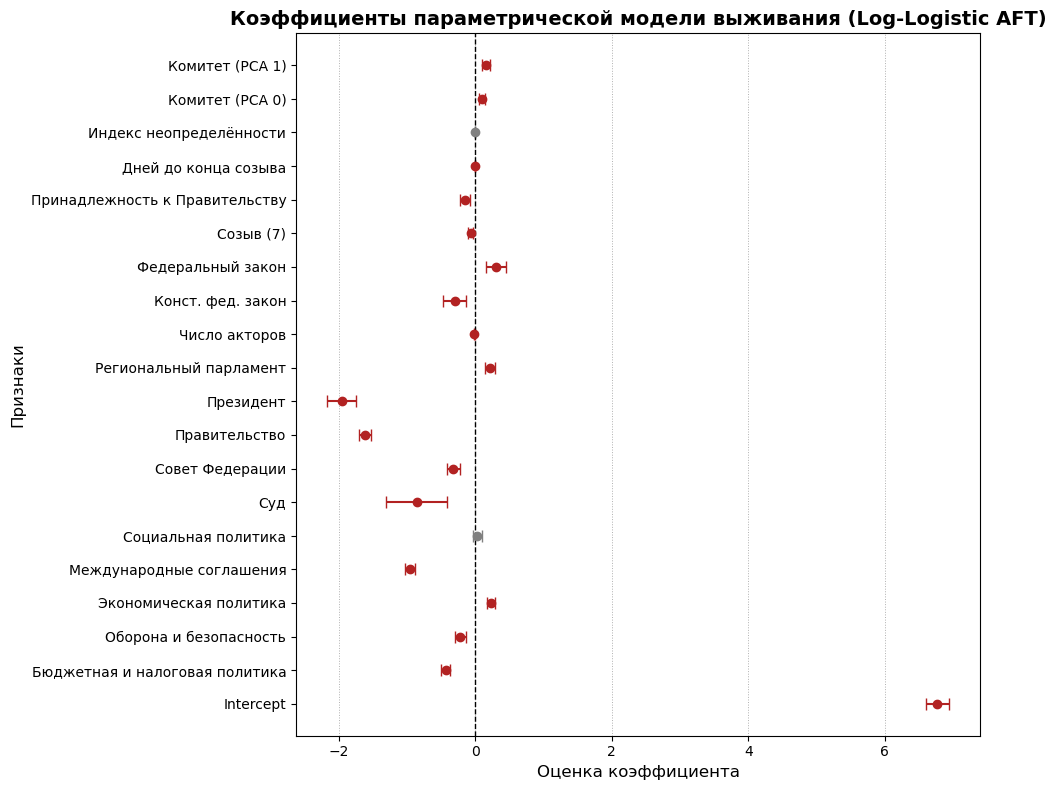

In [297]:
summary_final = summary_final.drop_duplicates(subset='Признак', keep='first')
coefs = summary_final['coef'].astype(float)
errors = summary_final['se(coef)'].astype(float)
labels_ru = summary_final['Признак']
significant = summary_final['p'].astype(float) < 0.05

plt.figure(figsize=(10, 8))
for i, (coef, err, sig) in enumerate(zip(coefs, errors, significant)):
    color = 'firebrick' if sig else 'gray'
    plt.errorbar(
        x=coef,
        y=i,
        xerr=1.96 * err,
        fmt='o',
        color=color,
        ecolor=color,
        capsize=4,
        label='_nolegend_'
    )

plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.yticks(range(len(labels_ru)), labels_ru, fontsize=10)
plt.xlabel('Оценка коэффициента', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.title('Коэффициенты параметрической модели выживания (Log-Logistic AFT)', fontsize=14, weight='bold')
plt.grid(axis='x', linestyle=':', linewidth=0.7)
plt.tight_layout()
plt.show()